In [22]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import copy
import seaborn as sns
from IPython.display import display
import xgboost as xgb
import re

### modAL 
from modAL.models import ActiveLearner 
from modAL.uncertainty import uncertainty_sampling, entropy_sampling

### sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



### Suppresses Warning
import warnings
warnings.filterwarnings('ignore')

In [23]:
MY_PC = '.'
MY_DRIVE = '/content/drive/MyDrive/KFUPM/ICS485 Machine Learning/machine-learning'


working_on = MY_PC

# Reading the data

In [24]:
train_data = pd.read_csv(working_on + "/preprocessed_data/train_data.csv")
val_data = pd.read_csv(working_on + "/preprocessed_data/val_data.csv")
test_data = pd.read_csv(working_on + "/preprocessed_data/test_data.csv")

### Some info of the labeled data

In [25]:
train_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X13_ FC11,X13_ FC13,X13_ FC14,X14_ CA23,X14_ CA50,X14_ CA59,Y
0,-1.520449,-1.428585,1.530877,-1.162058,-0.836349,-0.535183,-1.042610,-2.433676,-0.612921,-0.707368,0.0,0.0,1.0,0.0,0.0,0.0,Mercedes
1,0.019717,-0.578489,1.649464,-0.522458,-0.204228,-0.694313,1.210780,-1.719345,-2.155114,-0.453929,0.0,1.0,0.0,0.0,0.0,0.0,BMW
2,-1.149807,0.019739,0.226418,-0.658669,-0.263490,-0.870256,1.034734,0.185537,-0.753121,-0.819252,0.0,0.0,1.0,0.0,0.0,0.0,Honda
3,-1.708274,-0.415010,1.530877,-0.984392,-0.540042,-1.025183,1.316407,-1.147880,-1.944815,-0.890957,0.0,0.0,1.0,0.0,0.0,0.0,Honda
4,-1.034608,-0.534895,1.175115,0.667908,1.711888,-0.910489,1.210780,-1.100258,-1.734516,-0.234488,0.0,0.0,1.0,1.0,0.0,0.0,Mercedes


,Column,Non-Null Count,Dtype,Unique Values
Y,Y,6714,object,6
X1,X1,6714,float64,1393
X2,X2,6714,float64,2763
X3,X3,6714,float64,48
X4,X4,6714,float64,657
X5,X5,6714,float64,306
X6,X6,6714,float64,3077
X7,X7,6714,float64,167
X8,X8,6714,float64,131
X9,X9,6714,float64,243


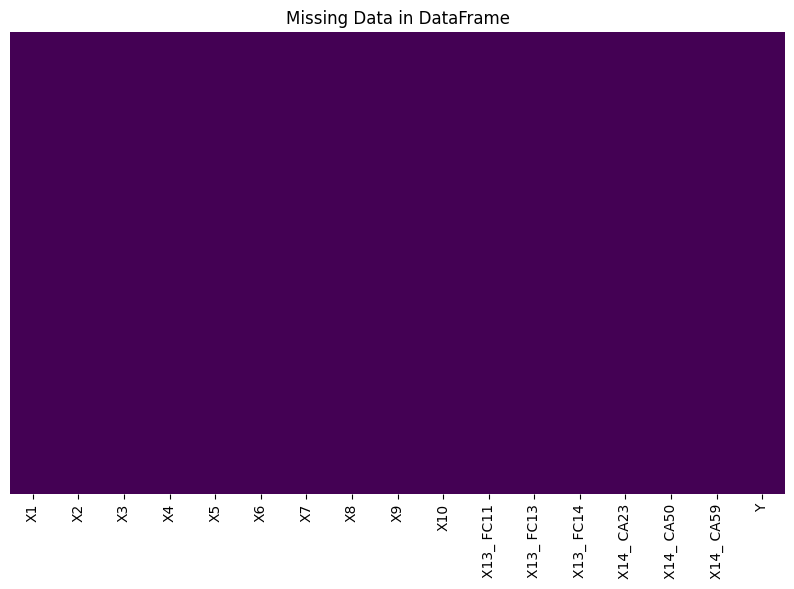

In [26]:
def display_dataframe_summary(dataframe, sort_by='Column'):

    summary = pd.DataFrame({
        'Column': dataframe.columns,
        'Non-Null Count': dataframe.notnull().sum(),
        'Dtype': dataframe.dtypes,
        'Unique Values': dataframe.nunique()
    })

    # Extracting numerical part from column names for sorting
    summary['Sort Key'] = summary['Column'].apply(lambda x: int(re.search(r'\d+', x).group()) if re.search(r'\d+', x) else 0)

    # Sorting the summary DataFrame
    if sort_by == 'Column':
        summary = summary.sort_values(by='Sort Key', ascending=True)
    else:
        summary = summary.sort_values(by=sort_by, ascending=True)

    summary = summary.drop('Sort Key', axis=1)  # Remove the auxiliary sort key column

    # Display the summary
    display(summary)

    # Plotting missing data
    plt.figure(figsize=(10, 6))
    sns.heatmap(dataframe.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.title('Missing Data in DataFrame')
    plt.show()

# Call the function with your DataFrame
display_dataframe_summary(train_data, sort_by='Column')


In [27]:
classes = train_data["Y"].unique()
number_of_classes = train_data["Y"].nunique()
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns

print(f"The classes is: {classes}")
print(f"Number of classes: {number_of_classes}")
print(categorical_cols)

The classes is: ['Mercedes' 'BMW' 'Honda' 'Toyota' 'GMC' 'Ford']
Number of classes: 6
Index(['Y'], dtype='object')


In [28]:
X_train = train_data.drop('Y', axis=1).to_numpy()
y_train = train_data['Y']
y_train = LabelEncoder().fit_transform(y_train)

X_val = val_data.drop('Y', axis=1).to_numpy()
y_val = val_data['Y']
y_val = LabelEncoder().fit_transform(y_val)

X_test = test_data.drop('Y', axis=1).to_numpy()
y_test = test_data['Y']
y_test = LabelEncoder().fit_transform(y_test)


queries = 50

### Splitting into training and pool

In [29]:
X_training, X_pool, y_training, y_pool = train_test_split(X_train,y_train,train_size=100, stratify=y_train, random_state=777)

In [30]:
X_training.shape, X_pool.shape

((100, 16), (6614, 16))

# Building Active learning

In [31]:
def get_next_sample(learner, X, y):
    
    # call the query strategy defined in the learner to obtain a new sample
    query_idx, query_sample = learner.query(X)
    
    # modify indexing to interpret as collection of one element with 26 features
    query_sample_reshaped = query_sample.reshape(1,-1)
   
    # obtain the query label
    query_label = y[query_idx]

    # modify indexing to interpret as 1D array of one element
    query_label_reshaped = query_label.reshape(1,)
    
    return query_sample_reshaped, query_label_reshaped, query_idx

In [32]:
def run_active_learner(learner, X_pool, y_pool, X_test, y_test, num_queries):
   
    history = [] # score history
    
    # score model before active learning starts
    history.append(learner.score(X_test,y_test))

    # perform active learning
    for idx in range(num_queries):

        # get sample
        X_sample, y_sample, query_idx = get_next_sample(learner, X_pool, y_pool)

        # use new sample to update the model
        learner.teach(X_sample, y_sample)

        # score against test data
        current_score = learner.score(X_test,y_test)

        # save score
        history.append(current_score)
        
        # remove labeled instance from pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)
        
    return history

In [33]:
# copy data for use with this section
X_pool_rand_rf = copy.deepcopy(X_pool)
y_pool_rand_rf = copy.deepcopy(y_pool)


# define learner, including training data as starting point
learner = ActiveLearner(
    estimator=xgb.XGBClassifier(n_estimators=1000, max_depth=7, learning_rate=0.1, random_state=777),
    query_strategy=uncertainty_sampling,
    X_training=X_training, 
    y_training=y_training
)


# run active learner and obtain score history
history_uncert_xgb = run_active_learner(learner,X_pool_rand_rf, y_pool_rand_rf, X_test, y_test, queries)

In [34]:
# final accuracay
print('Final accuracy of XGBooet with uncertainty sampling: \t{:.3f}'.format(history_uncert_xgb[-1]))

Final accuracy of XGBooet with uncertainty sampling: 	0.747


## Plot classification accuracy with respect to number of labels queried

In [35]:
def plot_performance_single_model(score_history):
    
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

    ax.plot(score_history)
    ax.scatter(range(len(score_history)), score_history, s=13)

    ax.set_ylim(bottom=0, top=1)
    ax.grid(True)

    ax.set_title('Incremental classification accuracy')
    ax.set_xlabel('Query iteration')
    ax.set_ylabel('Classification Accuracy')

    plt.show()

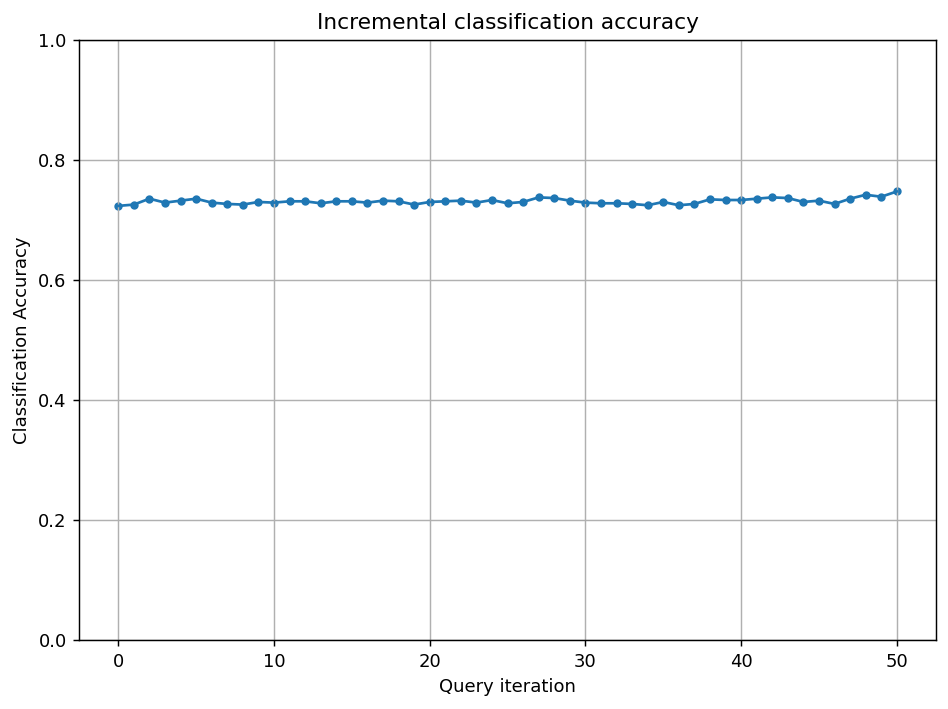

In [36]:
# plot our performance over time
plot_performance_single_model(history_uncert_xgb)

In [37]:
# copy data for use with this section
X_pool_rand_rf = copy.deepcopy(X_pool)
y_pool_rand_rf = copy.deepcopy(y_pool)


# define learner, including training data as starting point
learner = ActiveLearner(
    estimator=xgb.XGBClassifier(n_estimators=1000, max_depth=7, learning_rate=0.1, random_state=777),
    query_strategy=entropy_sampling,
    X_training=X_training, 
    y_training=y_training
)


# run active learner and obtain score history
history_entropy_xgb = run_active_learner(learner,X_pool_rand_rf, y_pool_rand_rf, X_test, y_test, queries)

In [38]:
# final accuracay
print('Final accuracy of Final accuracy of XGBooet with entropy sampling: \t{:.3f}'.format(history_entropy_xgb[-1]))

Final accuracy of Final accuracy of XGBooet with entropy sampling: 	0.735


## Plot classification accuracy with respect to number of labels queried

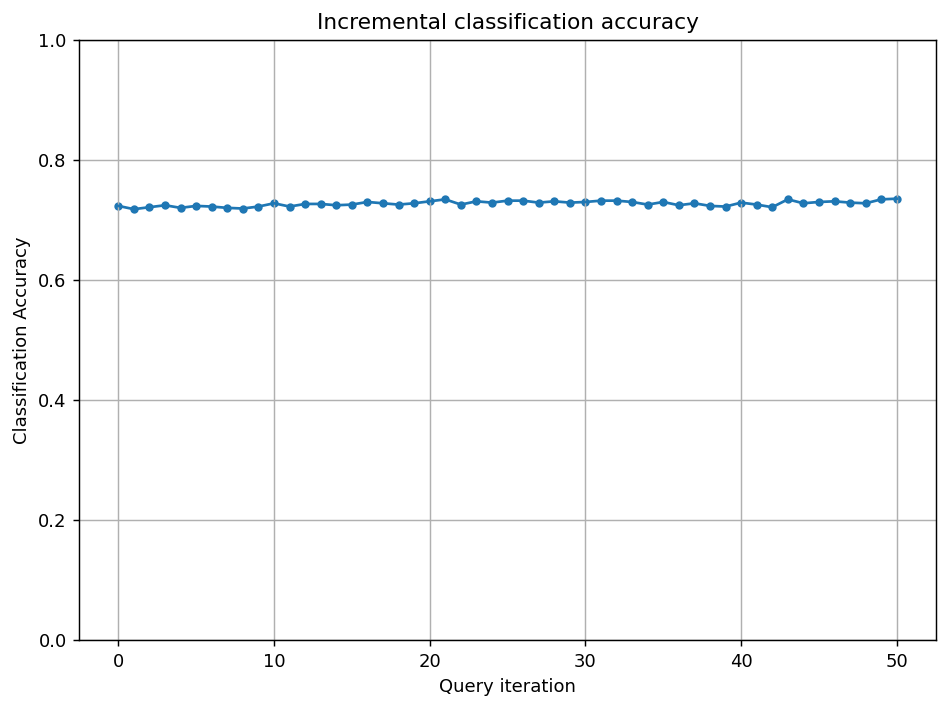

In [39]:
# plot our performance over time
plot_performance_single_model(history_entropy_xgb)

## Comparing Uncertainty and Entropy

In [40]:
def plot_performance_two_models(score_history_1, label_1, score_history_2, label_2):
    
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

    ax.plot(score_history_1)
    ax.scatter(range(len(score_history_1)), score_history_1, s=13, label = label_1)

    ax.plot(score_history_2)
    ax.scatter(range(len(score_history_2)), score_history_2, s=13, label = label_2)

    ax.set_ylim(bottom=0, top=1)
    ax.grid(True)

    ax.set_title('Incremental classification accuracy')
    ax.set_xlabel('Query iteration')
    ax.set_ylabel('Classification Accuracy')

    ax.legend()

    plt.show()

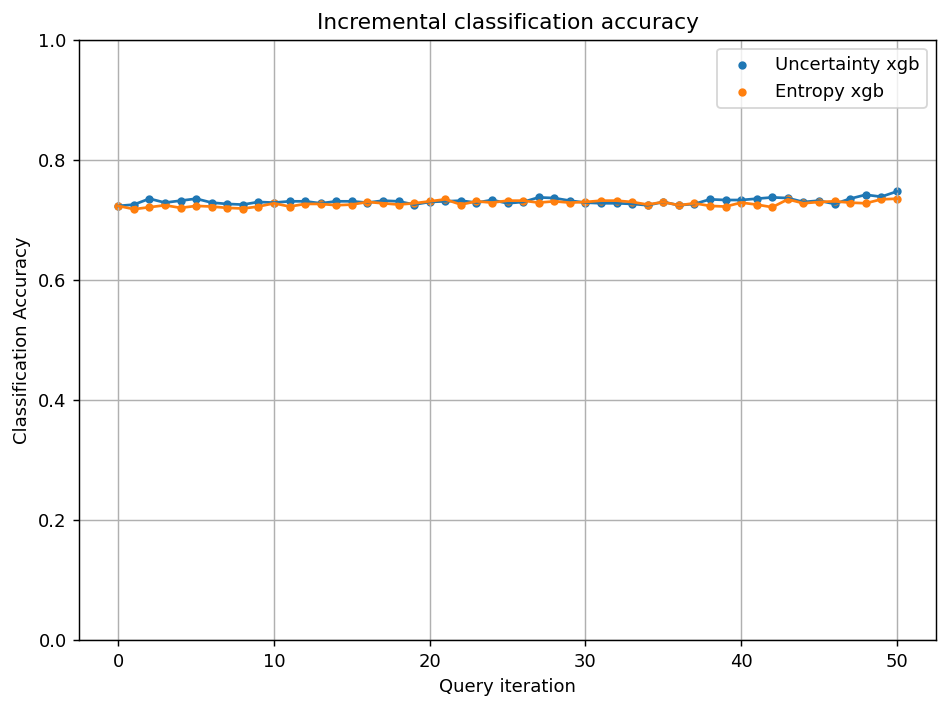

In [41]:
# plot our performance over time
plot_performance_two_models(history_uncert_xgb, 'Uncertainty xgb', history_entropy_xgb, 'Entropy xgb')